In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


class Dataset:
    """
    Representing dataset of images
    """

    def __init__(self, root_folder: str, img_format: format, images=None):
        self.root = root_folder
        self.img_format = img_format
        self.images_names = None
        self.images = images

    def load_dataset(self, root: str, img_format: str):
        """
        Loading dataset of images with concrete format from root folder
        :param root: root folder
        :param img_format: format of image
        :return: list of images
        """
        self.images = []
        self.images_names = []
        for file in os.listdir(root):
            title = file.title().lower()
            if title.split('.')[-1] == img_format:
                self.images_names.append(title)
                self.images.append(cv2.imread(os.path.join(root, title)))


def read_dataset(root: str, img_format: str):
    """
    Reading dataset of images with concrete format from root folder
    :param root: root folder
    :param img_format: format of image
    :return: list of images
    """
    images = []
    file_names = []
    for file in os.listdir(root):
        title = file.title().lower()
        if title.split('.')[-1] == img_format:
            file_names.append(title)
            images.append(cv2.imread(os.path.join(root, title)))
    return images

In [2]:
def bottom_hat_median_blurr(image):
    """
    Bottom hat filtering and smoothing with median filter
    :param image: image
    :return: filtered image
    """
    cimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    blackhat = cv2.morphologyEx(cimg, cv2.MORPH_BLACKHAT, kernel)
    bottom_hat_filtered = cv2.add(blackhat, cimg)
    return cv2.medianBlur(bottom_hat_filtered, 17)


def adjust_gamma(image, gamma=1.0):
    """
    Building a lookup table mapping the pixel values [0, 255] to
    their adjusted gamma values. Increasing contrast
    :param image: image
    :param gamma: adjusting coefficient
    :return: adjusted image
    """
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [3]:
def detect_circle(img, canny_param=20, hough_param=20):
    """
    Detecting inner iris circle after filtering
    :param img: image
    :param canny_param: higher threshold for canny edge detector
    :param hough_param: threshold parameter for Hough circle transform
    :return:
    """
    filtered = bottom_hat_median_blurr(img)
    adjusted = adjust_gamma(filtered, 10)
    circles = cv2.HoughCircles(adjusted, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=canny_param,
                               param2=hough_param,
                               minRadius=0)
    inner_circle = [0, 0, 0]
    if circles is not None:
        inner_circle = np.uint16(np.around(circles[0][0])).tolist()
        #outter_circle = np.uint16(np.around(circles[0][1])).tolist()
    return inner_circle #, outter_circle

In [4]:
def plot_images_grid(images, height, width):
    """
    Plotting height * width number of images from collection images
    in a grid form
    :param images: list of images
    :param height: number of images per column
    :param width: number of images per row
    """
    plt.subplots(figsize=(width * 2, height * 2))
    gs = gridspec.GridSpec(height, width)
    gs.update(wspace=0.05, hspace=0.05)
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if len(img.shape)==2:  #W*H, no channel
            plt.imshow(img,cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(img)

In [5]:
import os
import matplotlib.gridspec as gridspec
import cv2

root = "./dataset/"
images = read_dataset(root, "jpg")
print(len(images))
images[0].shape

6


(320, 320, 3)

In [6]:
for img in images:
    inner_circle = detect_circle(img)
    #cv2.circle(img,(outter_circle[0],outter_circle[1]),outter_circle[2],(0,255,0),2)   #result is not good.
    cv2.circle(img,(inner_circle[0],inner_circle[1]),inner_circle[2],(0,255,0),2) #draw the outer
    cv2.circle(img,(inner_circle[0],inner_circle[1]),2,(0,255,0),3) #draw the center

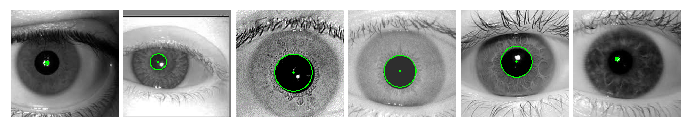

In [7]:
plot_images_grid(images, 1, 6)

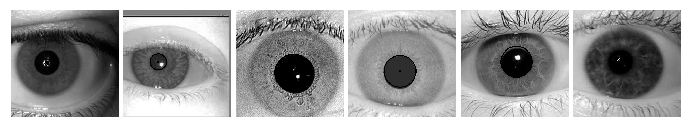

In [8]:
input_4d = np.stack(images, axis=0)
#RGB to Gray
input_4d = input_4d[:,:,:,2] #use R channel only
input_4d = input_4d.reshape(len(images),320,320,1)
input_4d_list = list(input_4d.reshape(len(images),320,320)) #batch*{320*320}
plot_images_grid(input_4d_list, 1, 6)

C:\Users\steph\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
(6, 320, 320, 1)


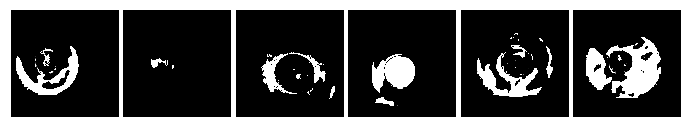

In [9]:
from keras.models import load_model
model = load_model('./Iris_unet_d5.h5')
output= model.predict(input_4d)
print(output.shape)
output_list = list(output.reshape(len(images),320,320))
plot_images_grid(output_list, 1, 6)

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 320, 320, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 320, 320, 64)  640         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 320, 320, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 160, 160, 64)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________